# Final Project
## Students: Luis Gustavo Avelino and Matheus Felizola
## Registration Number: 15/0016310 and 17/0019098

The purpose of this project is to build a classifier capable of interpreting single digits, from 0 to 9, 
O intuito desse projeto é criar um classificar que é capaz de interpretar números de 0 até 9  through images of the ASL (American Sign Language).

## Adding the dataset with images of ASL in the project

In [1]:
# Cloning the dataset repository
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 63.00 KiB/s, done.
Resolving deltas: 100% (658/658), done.


## Installing dependencies

In [2]:
# Installing tqdm library
!pip3 install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


## Importing useful Libraries

In [3]:
# Importing useful libraries: keras, numpy, tqdm, matplotlib...

import os, cv2, math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import numpy as np
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


## Exemplifying the Project


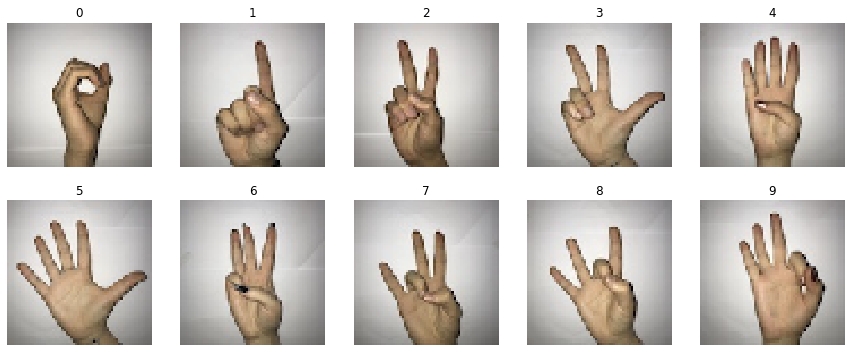

In [4]:
# Creating the example images for the numbers (10 numbers in total - 2 x 5)
number_of_rows, number_of_columns = 2, 5
plt.rcParams['figure.figsize'] = (number_of_columns * 3, number_of_rows * 3)

for row in range(number_of_rows):
    for column in range(number_of_columns):
        image_index = row * number_of_columns + column
        # Loading the images from the dataset
        digit_image = image.load_img('Sign-Language-Digits-Dataset/Examples/example_' + str(image_index) + '.JPG', target_size = (64, 64))
        plt.subplot(number_of_rows, number_of_columns, image_index + 1)
        plt.imshow(digit_image)
        plt.title(image_index)
        plt.axis('off')

As you can see in the images above each image, in ASL, represents a number. Out goal is to indetify the number form any given images. Our classifier should be able to identify the numbers from hands with different colors, unusual backgrounds, etc...

## Spliting the dataset in three different parts: training, validation and test.

In [5]:
# Creating the path to data downloaded dataset
PATH_TO_DATASET = 'Sign-Language-Digits-Dataset/Dataset/'

In [6]:
# Initialising the empty lists for each dataset
train_dataset = {}
validation_dataset = {}
test_dataset = {}

for cat in os.listdir(PATH_TO_DATASET):
    cat_dir = os.path.join(PATH_TO_DATASET, cat) # e.g. DATASET_PATH/'0'
    cat_files = os.listdir(cat_dir)
    
    # Size of training dataset will be 70% of the total dataset
    train_list , test_list = train_test_split(cat_files, test_size = 0.3)
    
    # Both test and validation datasets are 15% of the total dataset
    validation_list, test_list = train_test_split(test_list, test_size = 0.5)
    
    train_dataset[cat] = train_list
    validation_dataset[cat] = validation_list
    test_dataset[cat] = test_list

### Traning dataset

In [7]:
for cat in tqdm(train_dataset.keys()):
  cat_dir = os.path.join(PATH_TO_DATASET, 'training_dataset', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in train_dataset[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(PATH_TO_DATASET, cat, file)
    # dest path is DATASET_PATH/'training_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


### Validation Dataset

In [8]:
for cat in tqdm(validation_dataset.keys()):
  cat_dir = os.path.join(PATH_TO_DATASET, 'validation_dataset', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in validation_dataset[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(PATH_TO_DATASET, cat, file)
    # dest path is DATASET_PATH/'validation_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████| 10/10 [00:00<00:00, 59.45it/s]


### Test dataset

In [9]:
for cat in tqdm(test_dataset.keys()):
  cat_dir = os.path.join(PATH_TO_DATASET, 'test_dataset', 'class_0' + str(cat))
  os.makedirs(cat_dir)
  for file in test_dataset[cat]:
    # src path is DATASET_PATH/'0'/file
    src = os.path.join(PATH_TO_DATASET, cat, file)
    # dest path is DATASET_PATH/'test_set'/'class_00'
    # to accomodate for the directory format required by flow_from_directory method in keras
    dest = os.path.join(cat_dir, file)
    copyfile(src, dest)

100%|██████████| 10/10 [00:00<00:00, 60.17it/s]


In [10]:
# Printing the amount of images for each class in each dataset
for index in range(10):
  train_size = len(train_dataset[str(index)])
  validation_size = len(validation_dataset[str(index)])
  test_size = len(test_dataset[str(index)])
  print("0{} : Training size({}) Validation size({}) Test size({})".format(index, train_size, validation_size, test_size))

00 : Training size(143) Validation size(31) Test size(31)
01 : Training size(144) Validation size(31) Test size(31)
02 : Training size(144) Validation size(31) Test size(31)
03 : Training size(144) Validation size(31) Test size(31)
04 : Training size(144) Validation size(31) Test size(32)
05 : Training size(144) Validation size(31) Test size(32)
06 : Training size(144) Validation size(31) Test size(32)
07 : Training size(144) Validation size(31) Test size(31)
08 : Training size(145) Validation size(31) Test size(32)
09 : Training size(142) Validation size(31) Test size(31)


## Data Augmentation

In [11]:
# Perfoming data augmentation on training dataset
train_data_generator = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# For validation dataset, only rescale the pictures
validation_data_generator = ImageDataGenerator(rescale = 1./255)

# For test dataset, only rescale the pictures
test_data_generator = ImageDataGenerator(rescale = 1./255)

training_data = validation_data_generator.flow_from_directory(os.path.join(PATH_TO_DATASET, 'training_dataset'), target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

validation_data = validation_data_generator.flow_from_directory(os.path.join(PATH_TO_DATASET, 'validation_dataset'), target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

test_data = test_data_generator.flow_from_directory(os.path.join(PATH_TO_DATASET, 'test_dataset'), target_size = (64, 64), batch_size = 32, class_mode = 'categorical')

Found 1438 images belonging to 10 classes.
Found 310 images belonging to 10 classes.
Found 314 images belonging to 10 classes.


## CNN Architecture

In [12]:
# Initialising the CNN Network
classifier = Sequential()

# Adding the first layer, followed by pooling, and dropout to reduce overfitting
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding the second layer, followed by pooling, and dropout to reduce overfitting
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Adding the third layer, followed by pooling, and dropout to reduce overfitting
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Flattening the input
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax')) # Each number (0...9)

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training the dataset

In [13]:
# Traning the dataset and checking the result with the accuracy

history = classifier.fit_generator(training_data,
                         steps_per_epoch = math.ceil(training_data.n / training_data.batch_size),
                         epochs = 100,
                         validation_data = validation_data,
                         validation_steps = math.ceil(validation_data.n / validation_data.batch_size))


Epoch 1/100
45/45 [==============================] - 14s 317ms/step - loss: 2.2989 - accuracy: 0.1210 - val_loss: 2.2509 - val_accuracy: 0.2129
Epoch 2/100
45/45 [==============================] - 11s 246ms/step - loss: 1.6088 - accuracy: 0.4590 - val_loss: 0.9508 - val_accuracy: 0.6710
Epoch 3/100
45/45 [==============================] - 12s 258ms/step - loss: 0.9096 - accuracy: 0.6836 - val_loss: 0.6758 - val_accuracy: 0.8032
Epoch 4/100
45/45 [==============================] - 13s 283ms/step - loss: 0.6305 - accuracy: 0.7879 - val_loss: 0.4742 - val_accuracy: 0.8290
Epoch 5/100
45/45 [==============================] - 9s 202ms/step - loss: 0.4740 - accuracy: 0.8470 - val_loss: 0.4363 - val_accuracy: 0.8742
Epoch 6/100
45/45 [==============================] - 10s 224ms/step - loss: 0.3645 - accuracy: 0.8811 - val_loss: 0.3025 - val_accuracy: 0.9000
Epoch 7/100
45/45 [==============================] - 13s 294ms/step - loss: 0.3115 - accuracy: 0.8860 - val_loss: 0.4143 - val_accuracy:

45/45 [==============================] - 13s 289ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 4.9632e-04 - val_accuracy: 0.9742
Epoch 57/100
45/45 [==============================] - 10s 215ms/step - loss: 0.0039 - accuracy: 0.9979 - val_loss: 0.1814 - val_accuracy: 0.9710
Epoch 58/100
45/45 [==============================] - 9s 209ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.4146 - val_accuracy: 0.9710
Epoch 59/100
45/45 [==============================] - 16s 354ms/step - loss: 0.0065 - accuracy: 0.9972 - val_loss: 0.0175 - val_accuracy: 0.9806
Epoch 60/100
45/45 [==============================] - 11s 244ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9774
Epoch 61/100
45/45 [==============================] - 9s 197ms/step - loss: 0.0122 - accuracy: 0.9972 - val_loss: 0.0022 - val_accuracy: 0.9613
Epoch 62/100
45/45 [==============================] - 9s 208ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0022 - val_accuracy: 0.96

## Checking the accuracy

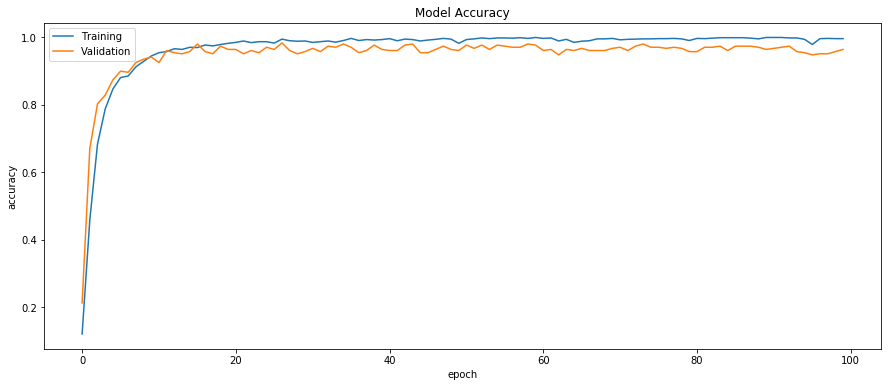

In [15]:
# Comparing the accuracy between the training dataset and the validation dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])

In [16]:
# Checking the test accuracy and the test loss
test_loss, test_accuracy = classifier.evaluate_generator(test_data, math.ceil(test_data.n / test_data.batch_size))
print("Accuracy on test set : {}".format(test_accuracy))

Accuracy on test set : 0.9458598494529724


## Final Results of the classifier

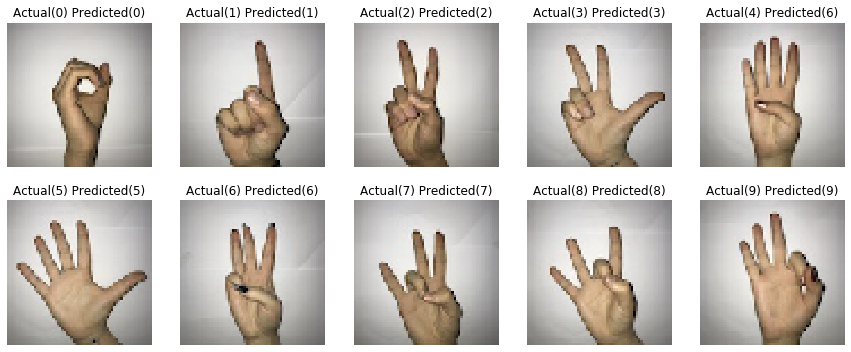

In [17]:
number_of_rows, number_of_columns = 2, 5
plt.rcParams['figure.figsize'] = (number_of_columns*3, number_of_rows*3)
for row in range(number_of_rows):
    for column in range(number_of_columns):
        image_index = row * number_of_columns + column
        # load image
        digit_image = image.load_img('Sign-Language-Digits-Dataset/Examples/example_' + str(image_index) + '.JPG', target_size = (64, 64))
        # convert image into array for prediction
        test_image = image.img_to_array(digit_image)
        test_image = np.expand_dims(test_image, axis = 0)
        # predict image using classifier
        result = classifier.predict(test_image).argmax()
        plt.subplot(number_of_rows, number_of_columns, image_index + 1)
        plt.imshow(digit_image)
        plt.title("Actual({}) Predicted({})".format(image_index, result))
        plt.axis('off')

## Saving the Model for future use

In [19]:
# save the models and weight for future purposes
# serialize model to JSON
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
pip install -U coremltools

     |████████████████████████████████| 4.0MB 2.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
# Convert it with default input and output names
import coremltools

# Saving the Core ML model to a file.
coreml_model = coremltools.converters.keras.convert(classifier,
                                                    input_names = 'image',
                                                   image_input_names = 'image')
coreml_model.save('my_model.mlmodel')


0 : conv2d_1_input, <keras.engine.input_layer.InputLayer object at 0x1a5108d668>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x1a50e52a90>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x1a5ff55710>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x1a502919b0>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x1a50e8e6d8>
5 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x1a5ff550b8>
6 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x1a5108d2e8>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x1a50e72128>
8 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x1a5ff555f8>
9 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x1a50ea4198>
10 : flatten_1, <keras.layers.core.Flatten object at 0x1a50eca780>
11 : dense_1, <keras.layers.core.Dense object at 0x1a50eb1a58>
12 : dense_1__activation__, <keras.layers.core.Activation object at 0x1a5ff55860>
13

## References

* https://github.com/ardamavi/Sign-Language-Digits-Dataset
* DORGAM, Diego. Redes Neurais Convolucionais - Aula 5. 2º/2019. 64 Slides. Material apresentado para a disciplina de Tópicos Especiais em Engenharia de Software da UnB, FGA.